In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import h5py
from mpl_toolkits import mplot3d
import itertools
import matplotlib

# View raw point data

In [11]:
Ndomain = 8                      # Number of subdomains
Ndim = 3                         # Number of physical dimensions

with h5py.File('turf.h5', 'r') as fd:
    pts = fd['fields/coords'][:]
    qoi = fd['fields/ni'][:]  # (Npts, Ndomain, Nsave)
    attrs = dict(fd['fields'].attrs)
    grid_domain = attrs['grid_domain']
    Nx, Ny, Nz = attrs['grid_shape']
    dx, dy, dz = attrs['grid_spacing']
    grid_spacing = (dx, dy, dz)
    grid_shape = (Nx, Ny, Nz)
    dt = attrs['dt'] * attrs['iters_per_save']
    Ndomain = attrs['Ndomain']
    Nsave = int(attrs['Nsave'])
    cmap = 'bwr'
    permute_axes = (2, 1, 0, 3, 4)
    qoi3d = qoi.reshape((int(Nz / 2), int(Ny / 2), int(Nx / 2), Ndomain, Nsave))     # (Z, Y, X, Ndomain, Nsave)
    qoi3d = np.transpose(qoi3d, axes=permute_axes)
    pts3d = pts.reshape((int(Nz / 2), int(Ny / 2), int(Nx / 2), Ndim, Ndomain))      # This array comes out as (Z, Y, X, 3d, Ndomain)
    pts3d = np.transpose(pts3d, axes=permute_axes)                                   # Now in the order (X,Y,Z, 3d, Ndomain)

def plot3d():
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    # ax.axes.set_xlim3d(left=-2, right=10)
    # ax.axes.set_ylim3d(bottom=0, top=10)
    # ax.axes.set_zlim3d(bottom=0, top=10)
    ax.set_xlabel('Axial (x)')
    ax.set_ylabel('Radial (y)')
    ax.set_zlabel('Transverse (z)')
    ax.xaxis.set_pane_color((1, 1, 1, 0))
    ax.yaxis.set_pane_color((1, 1, 1, 0))
    ax.zaxis.set_pane_color((1, 1, 1, 0))
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    return fig, ax

pts.shape, qoi.shape, (Nx, Ny, Nz)

((150000, 3, 8), (150000, 8, 250), (120, 100, 100))

In [4]:
pts3d.shape, qoi3d.shape

((60, 50, 50, 3, 8), (60, 50, 50, 8, 250))

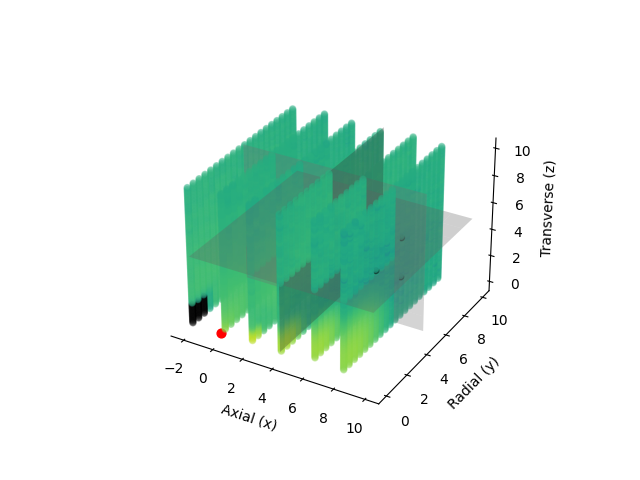

In [5]:
# Plot the 8 subdomains on one graph
fig, ax = plot3d()

# Gray dividing planes
X, Z = np.meshgrid(np.linspace(-2, 10, 10), np.linspace(0, 10, 10))
ax.plot_surface(X, 5, Z, color=(0.5, 0.5, 0.5), alpha=0.3)
Y, Z = np.meshgrid(np.linspace(0, 10, 10), np.linspace(0, 10, 10))
ax.plot_surface(4, Y, Z, color=(0.5, 0.5, 0.5), alpha=0.3)
X, Y = np.meshgrid(np.linspace(-2, 10, 10), np.linspace(0, 10, 10))
ax.plot_surface(X, Y, 5*np.ones(X.shape), color=(0.5, 0.5, 0.5), alpha=0.3)

# Thruster location
ax.scatter(0, 0, 0, color='r', s=40)

# Subdomains
skip = 100
sl = slice(0, pts.shape[0], skip)
c = ['r', 'g', 'b', 'c', 'm', 'y', 'sienna', 'lime']
labels = ['000', '001', '010', '011', '100', '101', '110', '111']
vmin, vmax = np.min(qoi[..., -1]), np.max(qoi[..., -1])
for i in range(Ndomain):
    # ax.scatter(pts[sl, 0, i], pts[sl, 1, i], pts[sl, 2, i], color=c[i], label=labels[i], alpha=0.2)
    sc = ax.scatter(pts[sl, 0, i], pts[sl, 1, i], pts[sl, 2, i], c=qoi[sl, i, -1], label=labels[i], alpha=0.4, cmap='viridis', norm='log', vmin=1, vmax=vmax)
    # cb = fig.colorbar(sc, label='Ion density (log10)')

In [6]:
# Stick the subdomains together
subdomains = list(itertools.product([0, 1], repeat=3))
pts_full = np.empty((Nx, Ny, Nz, 3))
qoi_full = np.empty((Nx, Ny, Nz, Nsave))
sub_shape = (int(Nx/2), int(Ny/2), int(Nz/2))
for i, subdomain in enumerate(subdomains):
    xs, ys, zs = [ele * sub_shape[j] for j, ele in enumerate(subdomain)]
    xe, ye, ze = xs+int(Nx/2), ys+int(Ny/2), zs+int(Nz/2)  # 8 equal cube subdomains
    pts_full[xs:xe, ys:ye, zs:ze, :] = pts3d[..., i]
    qoi_full[xs:xe, ys:ye, zs:ze, :] = qoi3d[..., i, :]

In [7]:
qoi_full.shape, pts_full.shape

((120, 100, 100, 250), (120, 100, 100, 3))

In [12]:
# Find the indices of nearest slice locations and plot
loc = [0, 4, 6]
axis = 1
slice_idx = []
domains = [(grid_domain[i, 0], grid_domain[i, 1]) for i in range(3)]  # For (x,y,z)
grids = [np.linspace(lb + grid_spacing[i]/2, ub - grid_spacing[i]/2, grid_shape[i])
         for i, (lb, ub) in enumerate(domains)]
slice_idx = [int(np.argmin(np.abs(grids[axis] - l))) for l in loc]
pts_slice = np.take(pts_full, slice_idx, axis=axis)
qoi_slice = np.take(qoi_full, slice_idx, axis=axis)

pts_slice.shape, qoi_slice.shape

((120, 3, 100, 3), (120, 3, 100, 250))

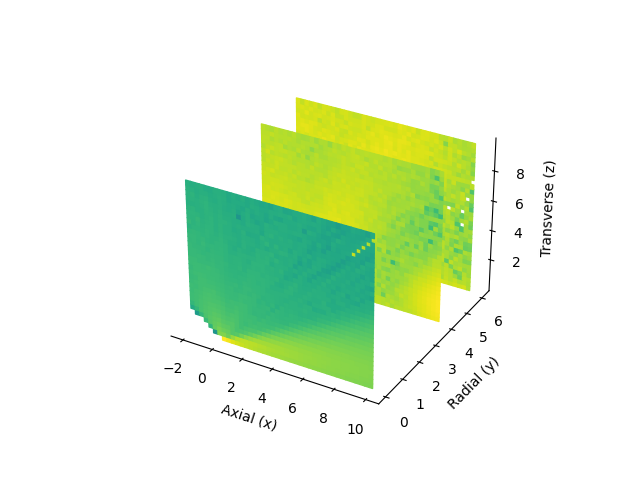

In [15]:
fig, ax = plot3d()
colors = plt.get_cmap('jet')(np.linspace(0, 1, len(slice_idx)))
for i in range(len(slice_idx)):
    X = np.take(pts_slice[..., 0], i, axis=axis)
    Y = np.take(pts_slice[..., 1], i, axis=axis)
    Z = np.take(pts_slice[..., 2], i, axis=axis)
    C = np.take(qoi_slice[..., -1], i, axis=axis)
    vmin, vmax = np.min(C+1), np.max(C)
    norm = matplotlib.colors.LogNorm(vmin, vmax)
    m = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
    m.set_array([])
    fcolors = m.to_rgba(C)
    ax.plot_surface(X, Y, Z, rcount=40, ccount=40, facecolors=fcolors, vmin=vmin, vmax=vmax, shade=False)
    # ax.plot_surface(X, Y, Z, color=colors[i], alpha=0.8)

In [27]:
thresh = 10
qoi_full[qoi_full < thresh] = np.nan
new_thresh = np.nanmin(qoi_full)
qoi_full[np.isnan(qoi_full)] = new_thresh

In [40]:
fcolors.shape

(120, 100, 4)

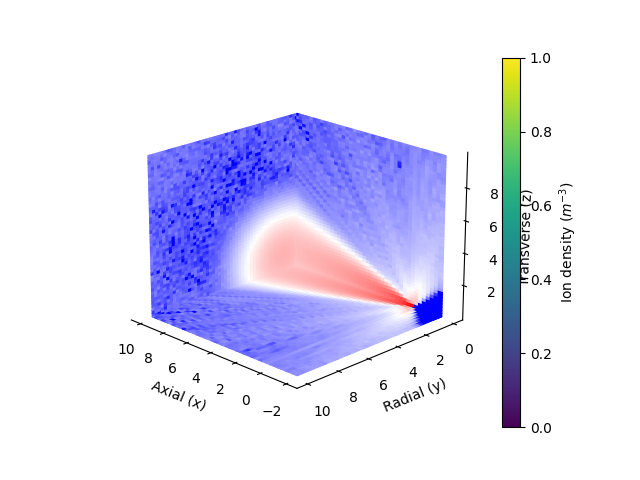

In [38]:
# Plot X,Y,Z cuts of final time snapshot
fig, ax = plot3d()
ax.view_init(elev=20, azim=135)
vmin, vmax = [], []
slice_indices = (-1, 0, 0)
for i, slice_idx in enumerate(slice_indices):
    qoi_slice = np.take(qoi_full[..., -1], slice_idx, axis=i)
    vmin.append(np.nanmin(qoi_slice+1))
    vmax.append(np.nanmax(qoi_slice))
vmin, vmax = np.min(vmin), np.max(vmax)

for i, slice_idx in enumerate(slice_indices):
    qoi_slice = np.take(qoi_full[..., -1], slice_idx, axis=i)
    pts_slice = np.take(pts_full, slice_idx, axis=i)
    X, Y, Z = pts_slice[..., 0], pts_slice[..., 1], pts_slice[..., 2]
    # vmin, vmax = np.min(C+1), np.max(C)
    norm = matplotlib.colors.LogNorm(vmin, vmax)
    m = plt.cm.ScalarMappable(norm=norm, cmap='bwr')
    m.set_array([])
    fcolors = m.to_rgba(qoi_slice)
    im = ax.plot_surface(X, Y, Z, rcount=50, ccount=50, facecolors=fcolors, vmin=vmin, vmax=vmax, shade=False)
    im.cmap.set_bad(im.cmap.get_under())
cb = fig.colorbar(im, label=r'Ion density ($m^{-3}$)')
    # ax.plot_surface(X, Y, Z, color=colors[i], alpha=0.8)

# View ion density data

In [108]:
qoi_plot = np.mean(qoi[..., -20:], axis=-1)  # (Npts, Ndomain)

fig, ax = plot3d()
X, Z = np.meshgrid(np.linspace(-2, 10, 10), np.linspace(0, 10, 10))
ax.plot_surface(X, 5, Z, color=(0.5, 0.5, 0.5), alpha=0.3)
Y, Z = np.meshgrid(np.linspace(0, 10, 10), np.linspace(0, 10, 10))
ax.plot_surface(4, Y, Z, color=(0.5, 0.5, 0.5), alpha=0.3)
X, Y = np.meshgrid(np.linspace(-2, 10, 10), np.linspace(0, 10, 10))
ax.plot_surface(X, Y, 5*np.ones(X.shape), color=(0.5, 0.5, 0.5), alpha=0.3)
ax.scatter(0, 0, 0, color='r', s=40)

# Subdomains
skip = 50
sl = slice(0, pts.shape[0], skip)
c = ['r', 'g', 'b', 'c', 'm', 'y', 'sienna', 'lime']
labels = ['000', '001', '010', '011', '100', '101', '110', '111']
i = 4


In [133]:
pts_lst = pts_full.reshape((-1, 3))
qoi_lst = qoi_full.reshape((-1))
ix = np.random.choice(pts_lst.shape[0], size=10000, replace=False)

In [137]:
fig, ax = plot3d()
ax.scatter(pts_lst[ix, 0], pts_lst[ix, 1], pts_lst[ix, 2], c=qoi_lst[ix], alpha=0.2, cmap='jet', norm='log')

In [149]:
fig, ax = plt.subplots()
im = ax.imshow(qoi_slice[:, 0, :].T, cmap='bwr', origin='lower', extent=[-2, 10, 0, 10], norm='log', interpolation='nearest')
im.cmap.set_bad(im.cmap.get_under())
im.changed()
im_ratio = Nz / Nx
cb = fig.colorbar(im, label='Ion density', fraction=0.046*im_ratio, pad=0.04)